### **AGE PREDICTION**
###### Arnau Gómez i Gabriel Gausachs

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR
from collections import OrderedDict

import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=5fe85c6c0504bb6f2984da381a1f5b27f0884add805cc3d3800939379fe441e5
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: 1604373 (wachiarnau). Use `wandb login --relogin` to force relogin


True

#### **Classes per llegir les dades del dataset i fer les transformacions pertinents**

In [ ]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
from pathlib import Path
import cv2
import pandas as pd
from PIL import Image

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.OneOf([
                iaa.Sometimes(0.25, iaa.AdditiveGaussianNoise(scale=0.1 * 255)),
                iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0)))
                ]),
            iaa.Affine(
                rotate=(-20, 20), mode="edge",
                scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}
            ),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
            iaa.GammaContrast((0.3, 2)),
            iaa.Fliplr(0.5),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.aug.augment_image(img)
        return img

class FaceDataset(Dataset):
    def __init__(self, data_dir, data_type, img_size=224, augment=None,transf=None):
        assert(data_type in ("train", "valid", "test"))
        pathcsv = Path(data_dir).joinpath(f"gt_avg_{data_type}.csv")
        img_dir = Path(data_dir).joinpath(data_type)
        self.img_size = img_size
        self.augment = augment

        if augment==0:
          self.transform = lambda i: i #no modifica la imatge
        elif augment==1:
          self.transform = ImgAugTransform() 
          #aplica una serie de transformacions: (afegeix soroll, desenfoca, rotació..)
          #ajuda al model a generalitzar, a regularitzar i que no es centri en patrons especifics.
        else:
          self.transform = transf
            
        self.x = []
        self.y = []
        df = pd.read_csv(str(pathcsv))
        #ignore_path = Path(__file__).resolve().parent.joinpath("ignore_list.csv")
        ignore_img_names = list(pd.read_csv('./AppaRealAge/appa-real-release/ignore_list.csv')['img_name'].values)

        for _, row in df.iterrows():
            img_name = row["file_name"]

            if img_name in ignore_img_names:
                continue

            img_path = img_dir.joinpath(img_name + "_face.jpg")
            assert(img_path.is_file())
            self.x.append(str(img_path))
            self.y.append(row["real_age"])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment!=0 and self.augment!=1:
          img = Image.open(img_path)
          img=self.transform(img)
          return img,age
        else:
          img = cv2.imread(str(img_path), 1)
          img = cv2.resize(img, (self.img_size, self.img_size))
          img = self.transform(img).astype(np.float32)
          return torch.from_numpy(np.transpose(img, (2, 0, 1))),age
        #fem np.transpose perque torch espera que les imatges siguin (canal, altura, amplada)

def mostrar_imagen(dataset, indice):
    ruta_imagen = dataset.x[indice]
    print(ruta_imagen)
    imagen = mpimg.imread(ruta_imagen)
    plt.imshow(imagen)
    plt.axis('off')
    plt.show()

#### **Descarreguem zip de les dades. També hem d'incloure en la carpeta un arxiu anomenat 'ingore_list.csv' amb imatges que no volem que afagi.**

In [ ]:
url= 'http://158.109.8.102/AppaRealAge/appa-real-release.zip'
datasets.utils.download_and_extract_archive(url, './AppaRealAge')

100%|██████████| 885442010/885442010 [02:36<00:00, 5661546.99it/s]


Extracting ./AppaRealAge/appa-real-release.zip to ./AppaRealAge


train dataset len: 3995
valid dataset len: 1500
test dataset len: 1978
AppaRealAge/appa-real-release/test/005621.jpg_face.jpg


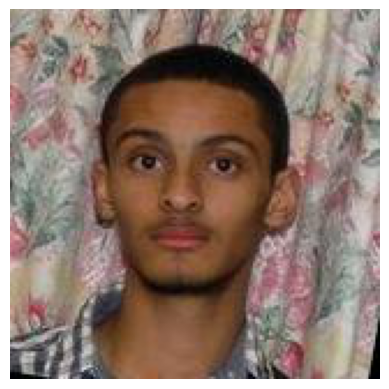

16


In [ ]:
data_dir = "./AppaRealAge/appa-real-release"
dataset = FaceDataset(data_dir, "train", True)
print("train dataset len: {}".format(len(dataset)))
dataset = FaceDataset(data_dir, "valid", True)
print("valid dataset len: {}".format(len(dataset)))
dataset = FaceDataset(data_dir, "test", True)
print("test dataset len: {}".format(len(dataset)))
mostrar_imagen(dataset,8)
print(dataset.y[8])

#### **Funció Model. Utilitzem transfer learning. Canviem la última capa perque s'ajusti al que volem fer (classificació: sortida de 101 classes; regressió: sortida d'un valor)**

In [ ]:
import torch.nn as nn
#import pretrainedmodels
#import pretrainedmodels.utils

def get_model(num_classes=101, tipus=None):
  if tipus=='classificació':
    # Resnet18 with pretrained weights 
      model = models.resnet34(weights=True) # Notice we are now loading the weights of a ResNet model trained on ImageNet
      model.fc = nn.Linear(in_features=512,out_features=num_classes)
      return model
  else:
    model = models.resnet34(weights=True) # Notice we are now loading the weights of a ResNet model trained on ImageNet
    model.fc = nn.Linear(in_features=512,out_features=1)
    return model

  
print(get_model(101,'classificació'))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### **Funció Model. Utilitzem transfer learning. Canviem la última capa perque s'ajusti al que volem fer (classificació: sortida de 101 classes; regressió: sortida d'un valor). Fem feature_extraction per veure si aconseguim evitar possible overfitting**

In [ ]:
import torch.nn as nn
#import pretrainedmodels
#import pretrainedmodels.utils

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def get_model_fe(num_classes=101, tipus=None):
  if tipus=='classificació':
    # Resnet18 with pretrained weights 
      model = models.resnet34(weights=True) # Notice we are now loading the weights of a ResNet model trained on ImageNet
      set_parameter_requires_grad(model,True)
      model.fc = nn.Linear(in_features=512,out_features=num_classes)
      return model
  else:
    model = models.resnet34(weights=True) # Notice we are now loading the weights of a ResNet model trained on ImageNet
    set_parameter_requires_grad(model,True)
    model.fc = nn.Linear(in_features=512,out_features=1)
    return model

#### **Funció Train_model_ce. Basada en la funció de les entregues. Quan fem el validation, afegim el càlcul del MAE (mean absolut error).**

In [ ]:
def train_model_ce(model, dataloaders, criterion, optimizer, num_epochs=5,name_project=None,name_run=None):
    wandb.init(project=name_project,name=name_run)
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            prediccions=[]
            gt=[]

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                  if phase=='train':
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.item())

                    _, preds = outputs.max(1)
                    correct_num = preds.eq(labels).sum().item()
                    #print(correct_num)
                        
                    # backward + optimize only if in training phase
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                  else:
                    outputs = model(inputs)
                    probs = F.softmax(outputs, dim=1)
                    _, predicted = torch.max(probs, dim=1)
                    prediccions.append(predicted.cpu().numpy())
                    gt.append(labels.cpu().numpy())

                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.item())

                    _, preds = outputs.max(1)
                    correct_num = preds.eq(labels).sum().item()
                    #print(correct_num)


                # statistics
                running_loss += loss.item() * inputs.size(0)
                #print(torch.sum(preds==labels.data))
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase=='val':
              prediccions = np.concatenate(prediccions, axis=0)
              gt = np.concatenate(gt, axis=0)
              mse = np.square(prediccions - gt).mean()

              wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_accuracy": epoch_acc, f"{phase}_mse": mse})
            else:
              wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_accuracy": epoch_acc})



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase=='val':
              print('{} MSE: {:.4f}'.format(phase, mse))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses

#### **Funció Train_model_mse. Basada en la funció de les entregues. Usem MSELoss() i per tant no fem ús de variables per el calcul de l'accuracy.**

In [ ]:
def train_model_mse(model, dataloaders, criterion, optimizer, num_epochs=5,name_project=None,name_run=None):
    wandb.init(project=name_project,name=name_run)
    since = time.time()

    losses = {"train": [], "val": []}
    best_loss=10000000000

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.float()


                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                  if phase=='train':
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    outputs = outputs.float()
                    labels = labels.view(-1, 1)  # Cambiar la forma de las etiquetas a [128, 1]

                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.item())
                        
                    # backward + optimize only if in training phase
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                  else:
                    outputs = model(inputs)
                    outputs = outputs.float()
                    labels = labels.view(-1, 1)  # Cambiar la forma de las etiquetas a [128, 1]

                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.item())
                    #print(correct_num)


                # statistics
                running_loss += loss.item() * inputs.size(0)
                #print(torch.sum(preds==labels.data))

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            wandb.log({f"{phase}_loss": epoch_loss})



            print('{} Loss: {:.4f}'.format(phase, epoch_loss))


            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses

#### **Executem tot. Llegim les dades, fem els dataloaders, definim la loss, el optimizer i cridem a la funció train_model perque entreni el model i l'evaluï.**

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="appa_real_customtransform_resnet34_mse_15",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "Resnet34",
    "dataset": "ImageNet",
    "epochs": 15,
    }
)

In [ ]:
from torch.utils.data import DataLoader

model = get_model(1,'regressió')
# Send the model to GPU
model = model.to(device)

name_project='appa_real_customtransform_resnet34_mse_15'
name_run='finetun_16'

# Setup the loss fxn
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 15

#params_to_update = []
#for name,param in model.named_parameters():
#    if param.requires_grad == True:
#        params_to_update.append(param)

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
#optimizer_ft = optim.Adam(params_to_update, lr=0.001)

custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor()])

train_dataset = FaceDataset(data_dir, "train",augment=2,transf=custom_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          num_workers=2, drop_last=True)

val_dataset = FaceDataset(data_dir, "valid",augment=2,transf=custom_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                        num_workers=2, drop_last=False)

dataloaders_dict = {}
dataloaders_dict['train']=train_loader
dataloaders_dict['val']=val_loader

# Train and evaluate
model, losses = train_model_mse(model, dataloaders_dict, criterion, optimizer_ft, num_epochs,name_project,name_run)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▂▂▂▂▁▂▁
train_loss,186.5189
val_loss,187.33426


Epoch 0/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc29ac54dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc29ac54dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

train Loss: 254.6185
val Loss: 391.2564

Epoch 1/14
----------
train Loss: 160.8091
val Loss: 299.7315

Epoch 2/14
----------
train Loss: 135.5289
val Loss: 136.2396

Epoch 3/14
----------
train Loss: 114.8942
val Loss: 162.8894

Epoch 4/14
----------
train Loss: 108.8185
val Loss: 166.0204

Epoch 5/14
----------
train Loss: 99.6066
val Loss: 139.6665

Epoch 6/14
----------
train Loss: 82.1980
val Loss: 158.6153

Epoch 7/14
----------
train Loss: 68.0822
val Loss: 115.0457

Epoch 8/14
----------
train Loss: 65.3869
val Loss: 129.3240

Epoch 9/14
----------
train Loss: 57.7113
val Loss: 112.5671

Epoch 10/14
----------
train Loss: 51.8605
val Loss: 113.8631

Epoch 11/14
----------
train Loss: 47.0121
val Loss: 114.8577

Epoch 12/14
----------
train Loss: 40.9048
val Loss: 128.4953

Epoch 13/14
----------
train Loss: 34.2115
val Loss: 154.0063

Epoch 14/14
----------
train Loss: 33.8112
val Loss: 158.1823

Training complete in 11m 22s
Best val loss: 112.567062


In [ ]:
wandb.finish()

train_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
val_loss,█▆▂▂▂▂▂▁▁▁▁▁▁▂▂
train_loss,33.81124
val_loss,158.18229


#### **Fem uns plots per veure l'accuracy i la loss. (utilitzem el codi proporcionat en les entregues)**

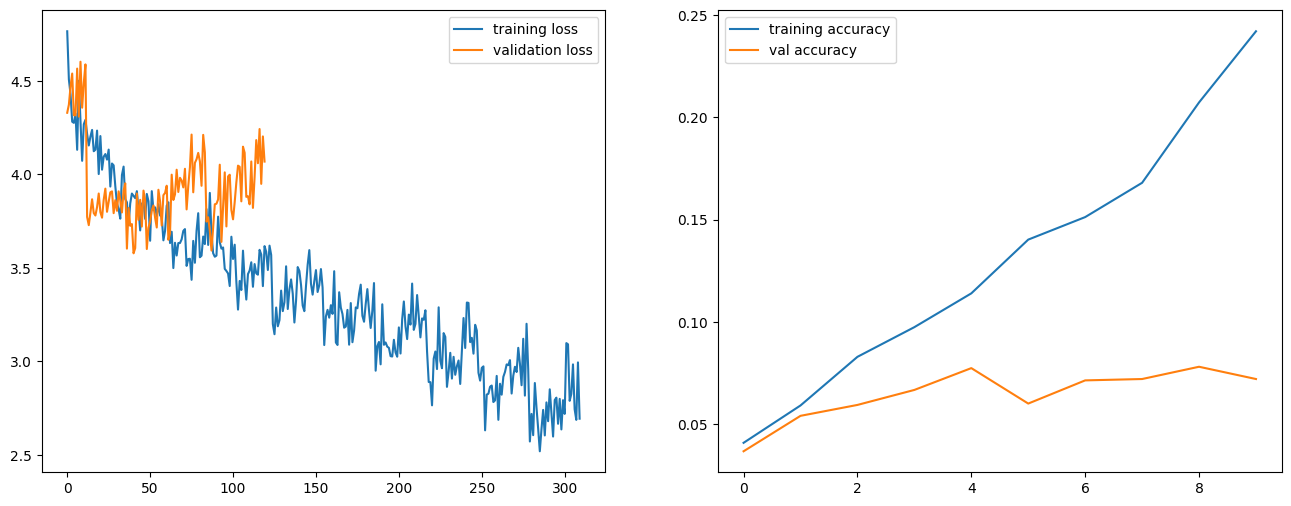

In [ ]:
# plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["val"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"],label="training accuracy")
ax2.plot(hist["val"],label="val accuracy")
ax2.legend()

plt.show()   

#### **Lectura del dataset AFAD**

In [ ]:
from PIL import Image

TRAIN_CSV_PATH = './afad_train.csv'
TEST_CSV_PATH = './afad_test.csv'
IMAGE_PATH = '/shared_datasets/AFAD/orig/tarball/AFAD-Full'


class AFADDatasetAge(Dataset):
    """Custom Dataset for loading AFAD face images"""

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_paths = df['path']
        
        #self.y = df['age'].values
        df['age_real'] = df['path'].str.extract(r'^(\d+)', expand=False)
        self.y = df['age_real'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_paths[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]


custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor()])

train_dataset = AFADDatasetAge(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform)


custom_transform2 = transforms.Compose([transforms.Resize((128, 128)),
                                        transforms.CenterCrop((120, 120)),
                                        transforms.ToTensor()])

test_dataset = AFADDatasetAge(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH,
                              transform=custom_transform2)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=256,
                         shuffle=False,
                         num_workers=2)
